# An example showing how to load data and a GPT baseline
This notebook will run you through an example to:
- Read the name of each body in the train assemblies (this can be expanded to read other information about the bodies, like their volume or corresponding image/STEP files)
- Read the ground truth material of each body
- Create a train/validation split to evaluate the effectiveness of the baseline
- Predict the material of each body just from its name using a Large Language Model (LLM)
- Evaluate the predictions of the validation data by calculating the f1 score and showing a confusion matrix

As we are using OpenAI's API, you will have to provide your own API key, or modify this code to use an open source LLM.

## Setup

In [1]:
import openai
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import backoff
import time
from collections import Counter
from sklearn.model_selection import train_test_split

Add your OpenAI API key here ([register for an OpenAI](https://openai.com/blog/openai-api/) key and take advantage of the free trial), or use an open source LLM

In [37]:
# openai.api_key  = "open_ai_key"


In [52]:
def get_completion(prompt='', model="gpt-3.5-turbo", temperature=0, max_tokens=200):
    messages = [{"role": "user", "content": prompt}]

    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=6
        )
        response = response.choices[0].message["content"]
    except openai.error.APIError as e:
        print(f"OpenAI API Error: {e}")
        response = "ERROR"
    except openai.error.APIConnectionError as e:
        print(f"OpenAI API Connection Error: {e}")
        response = "ERROR"
    except Exception as e:
        print(f"Exception: {e}")
        response = "ERROR"
    return response

@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def get_completion_with_backoff(**kwargs):
    time.sleep(0.1)
    return get_completion(**kwargs)

In [39]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [40]:
def id2name(id):
    id = id.lower()
    # id = id.rstrip()
    if id == 'metal_non-ferrous':
        return 'non-ferrous metal'
    elif id == 'metal_ferrous':
        return 'ferrous metal'
    elif id == 'metal_ferrous_steel':
        return 'steel'
    elif id == 'metal_aluminum':
        return 'aluminum'
    elif id in ['other', 'wood', 'plastic']:
        return id
    else:
        raise f"Non-default id! {id}"
        # return 'other'

In [41]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

In [42]:
def post_process_response(response):
    if 'non-ferrous metal' in response:
        return 'non-ferrous metal'
    elif 'aluminum' in response:
        return 'aluminum'
    elif 'steel' in response:
        return 'steel'
    elif 'wood' in response:
        return 'wood'
    elif 'plastic' in response:
        return 'plastic'
    elif 'ferrous metal' in response:
        return 'ferrous metal'
    elif 'other' in response:
        return 'other'
    else:
        # print(f"incorrect response: {response}\n")
        return 'other'

## Read the material and names of bodies in assemlies
Loop through each of the 'assembly.json' files in the dataset, and read the name and material_categeory of each body in the assembly.
As some bodies do not have a custom name, but the default name 'body#', we will filter those out as our LLM baseline cannot predict those.

In [65]:
# Change this to the directory where you downloaded the dataset
# input_dir = r"/mnt/audio_ml/IDETC23_data/Fusion360GalleryDataset_23hackathon_train"     
input_dir = r"/mnt/audio_ml/IDETC23_data/Fusion360GalleryDataset_23hackathon_test"
input_jsons = get_all_files(input_dir, "*/assembly.json")

In [ ]:
assemblies = {}
for input_json in tqdm(input_jsons):
    with open(input_json, "r", encoding="utf-8") as f:
        assembly_data = json.load(f)

    bodies = []
    for key, value in assembly_data['bodies'].items():
        name = value['name']
        material = value['material_category']

        if name[:4] != 'Body':  # some of the bodies do not have a custom name. This filters those bodies out.
            bodies.append({'name':name, 'material':material})

    if len(bodies) > 0:
        assemblies[input_json.parts[-2]] = bodies

In [67]:
print(f"Number of total assemblies in the training set: {len(input_jsons)}")
print(f"Number of assemblies that have at least one non-default part name: {len(assemblies)}")

Number of total assemblies in the training set: 10
Number of assemblies that have at least one non-default part name: 0


## Split the *train* set into *train* and *validation*

In [ ]:

body_list = [assembly_data for assembly_data in assemblies.values()]
train_assemblies, validation_assemblies = train_test_split(body_list, test_size=0.2, shuffle=True, random_state=0)

In [47]:
print(f"number of train assemblies: {len(train_assemblies)}")
print(f"number of validation assemblies: {len(validation_assemblies)}")

number of train assemblies: 932
number of validation assemblies: 233


## Make predictions for all bodies in the validation assemblies

In [69]:
# Deduplicate bodies that have the same name

body_names = []
materials = []

for assembly in validation_assemblies:
    for body in assembly:
        body_name = body['name']
        material = body['material']
        if body_name not in body_names:
            body_names.append(body_name)
            materials.append(material)

In [ ]:
print(f"Number of bodies before deduplication: {sum([len(assembly) for assembly in assemblies.values()])}")
print(f"Number of bodies after deduplication: {len(body_names)}")

In [79]:
prompt = """
The following is the name of a part in an assembly.
Given the name of the part, classify the material of the part as either of the following material categories: 'aluminum', 'ferrous metal', 'non-ferrous metal', 'steel', 'plastic', 'wood', or 'other'.
If you are unsure, please answer 'other'. Only respond with the material category.

"""

In [ ]:
predicted_materials = []

for body_name in tqdm(body_names):
    full_prompt = prompt + f"part name: {body_name}, material: "
    # print(full_prompt)

    response = get_completion_with_backoff(prompt=full_prompt)

    predicted_materials.append(response)
    # print(response)



In [56]:
print(f"This is an example prompt that we sent to the LLM:\n\n\n{full_prompt}")


This is an example prompt that we sent to the LLM:



The following is the name of a part in an assembly.
Given the name of the part, classify the material of the part as either of the following material categories: 'aluminum', 'ferrous metal', 'non-ferrous metal', 'steel', 'plastic', 'wood', or 'other'.
If you are unsure, please answer 'other'. Only respond with the material category.

part name: LockBolt4, material: 


In [57]:
print(f"This is an example reponse that we got from the LLM:\n\n\n{response}")

This is an example reponse that we got from the LLM:


steel


In [58]:
print(f"We can count how many instances of each response we got:\n\n\n{Counter(predicted_materials)}")

We can count how many instances of each response we got:


Counter({'other': 1479, 'plastic': 360, 'steel': 347, 'wood': 41, 'ferrous metal': 24, 'aluminum': 15, 'non-ferrous metal': 6, 'rubber': 4, 'ERROR': 1})


## Post-processing responses
As the LLM does not always do what we asked, we have to clean up the invalid responses.
Also, we will modify the material id of the ground truth data in `materials` to match the post-processed reponses, using the `id2name` function

In [59]:
predicted_materials_processed = [post_process_response(response) for response in predicted_materials]
materials_processed = [id2name(material) for material in materials]

In [60]:
print(f"We can count how many instances of each prediction we have after post-processing:\n\n{Counter(predicted_materials_processed)}")

We can count how many instances of each prediction we have after post-processing:

Counter({'other': 1484, 'plastic': 360, 'steel': 347, 'wood': 41, 'ferrous metal': 24, 'aluminum': 15, 'non-ferrous metal': 6})


## Evaluating the results
The confusion matrix and classification report are good ways to evaluate our method

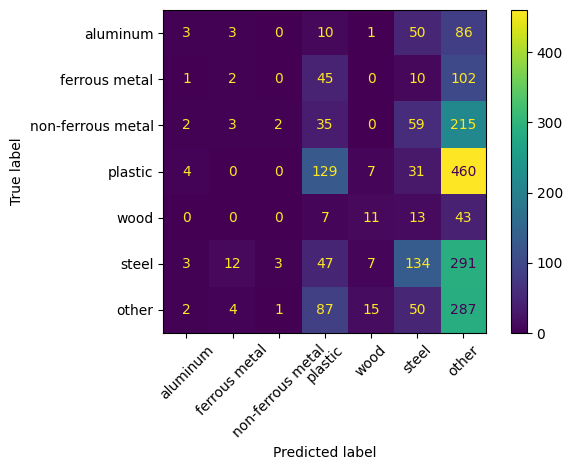

                   precision    recall  f1-score   support

         aluminum       0.20      0.02      0.04       153
    ferrous metal       0.08      0.01      0.02       160
non-ferrous metal       0.33      0.01      0.01       316
            other       0.19      0.64      0.30       446
          plastic       0.36      0.20      0.26       631
            steel       0.39      0.27      0.32       497
             wood       0.27      0.15      0.19        74

         accuracy                           0.25      2277
        macro avg       0.26      0.19      0.16      2277
     weighted avg       0.30      0.25      0.21      2277



In [61]:
classes = ['aluminum', 'ferrous metal', 'non-ferrous metal', 'plastic', 'wood', 'steel', 'other']
show_confusion_matrix(materials_processed, predicted_materials_processed, classes)
print(classification_report(materials_processed, predicted_materials_processed))

## Conclusion
From the results we can see that the model is not doing very well.
It achieves an accuracy of 0.26.
From the confusion matrix we can see that most of the bodies are classified as `other`.

This approach could be further improved by changing the prompt, providing more contextual information to the LLM, and many more ways.
We look forward to seeing your solutions!